### This code is inspired from the Facebook AI team where we built a [MultiModal Deep Learning Classification model](https://www.drivendata.co/blog/hateful-memes-benchmark/) using PyTorch and Facebook fasttext. 

**Major Changes:**


1.   We used the structure of the code and applied on our own dataset where we labelled the images on the Sarcasm. 
2.   We used different Linearity functions and Vision models. We fine tuned Hyper parameters to fit our requirements. Text pre-processing and manipulated the dimensions in a unique way.



---
### We built this model for experimentation purpose inorder to compare with our indigenous models with industry standard model for the MultiModality problem. 

**Note:** GPU is required to run the code so we used Google Colab Notebook.

In [ ]:
# Installing the required libraries in google colab
!pip install pandas_path
!pip install fasttext
!pip install pytorch_lightning==0.9.0

In [ ]:
#Importing standard libraries for building the model

%matplotlib inline
import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path  # Path style access for pandas
from tqdm import tqdm


In [ ]:
# libraries for building language and vision modules
import torch                    
import torchvision
import fasttext

In [ ]:
# mounting the google drive link for reading the data files
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# defining the path directories for all the files
main_dir = Path.cwd().parent / "content" / "gdrive" / "My Drive"/ "Colab_Notebooks"/ "data"
image_dir = main_dir / "img"
train_file = main_dir / "train_hate.jsonl"
val_file = main_dir / "val_sarcasm.jsonl"
test_file = main_dir / "test_sarcasm.jsonl"
main_file = main_dir / "Final_df.csv"

In [ ]:
# Reading the train file to see the structure of the data
df = pd.read_json(train_file,lines=True)
df.head()

,label,FB_text,text,sarcasm_label,img,id
0,0,okay now make sure to get my good side,okay now make sure to get my good side,1,img/36985.png,36985
1,1,"from here i will see muslims fuck up europe, a...",from here i will see muslim fuck up europe att...,1,img/43895.png,43895
2,1,"#lagostoibadan men are scum, men are scum but ...",lagos to ibadan men are scum men are scum but ...,1,img/67109.png,67109
3,0,stop editing your pics. what if you go missing...,stop ediing your ny what if you go missing how...,1,img/05931.png,5931
4,0,oh look he already has an arrest warrant,ooh look he already has the arrest warrant,0,img/40813.png,40813


In [ ]:
# Distribution of the labels
df.sarcasm_label.value_counts()

1    2247
0     968
Name: sarcasm_label, dtype: int64

In [ ]:
# This class is to define the dataset for the input to multimodal classification model
class SarcasmDataset(torch.utils.data.Dataset):
    """Reads the jsonl file and prepares the data for building multimodal tensors.
    """
    def __init__(
        self,
        main_path,
        image_file,
        img_model,
        txt_model,
        balance=False,
        val_limit=None,
        random_state=0,
    ):
        #importing the dataset from json format into dataframe
        self.data_frame = pd.read_json(   
            main_path, lines=True)
        self.val_limit = val_limit
        # Maintaining a balance by sampling to create a non-bias sample for training
        if balance:
            nonsarc = self.data_frame[
                self.data_frame.sarcasm_label.eq(0)
            ]
            sarc = self.data_frame[
                self.data_frame.sarcasm_label.eq(1)
            ]
            self.data_frame = pd.concat(
                [
                    nonsarc.sample(
                        sarc.shape[0], 
                        random_state=random_state, replace = True
                    ), 
                    sarc
                ]
            )
        # setting the sample limit as validation set 
        if self.val_limit:
            if self.data_frame.shape[0] > self.val_limit:
                self.data_frame = self.data_frame.sample(
                    val_limit, random_state=random_state
                )
        self.data_frame = self.data_frame.reset_index(
            drop=True
        )
        self.data_frame.img = self.data_frame.apply(
            lambda row: (image_file / row.img), axis=1
        )

        # reading the image files from a different folder through image path
        if not self.data_frame.img.path.exists().all():
            raise FileNotFoundError
        if not self.data_frame.img.path.is_file().all():
            raise TypeError
        # setting image and text models    
        self.img_model = img_model
        self.txt_model = txt_model

    def __len__(self):
        """This definition is for finding the lenght of an instance ex: len(instance).
        """
        return len(self.data_frame)

    def __getitem__(self, idx):
        """This method helps us to get values from the key-value pair.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # getting the image id based on the id number and saving in a variable
        img_id = self.data_frame.loc[idx, "id"]
        # Reading the image using PIL library to create tensors from image model
        image = Image.open(
            self.data_frame.loc[idx, "img"]
        ).convert("RGB")
        image = self.img_model(image)

        text = torch.Tensor(
            self.txt_model.get_sentence_vector(
                self.data_frame.loc[idx, "text"]
            )
        ).squeeze()
        # returning the values and labels
        if "sarcasm_label" in self.data_frame.columns:
            sarcasm_label = torch.Tensor(
                [self.data_frame.loc[idx, "sarcasm_label"]]
            ).long().squeeze()
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text, 
                "sarcasm_label": sarcasm_label
            }
        else:
            sample = {
                "id": img_id, 
                "image": image, 
                "text": text
            }

        return sample

In [ ]:
# This class defines the image and text models that we are using

class TextandImageModel(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        loss_fn,
        txt_module,
        img_module,
        txt_dim,
        img_dim,
        fusion_output_size,
        dropout_p,
        
    ):
        super(TextandImageModel, self).__init__()
        self.txt_module = txt_module
        self.img_module = img_module
        # Fusion model Linearly concats both the tensors/features and creates a fusion tensor 
        self.fusion = torch.nn.Linear(
            in_features=(txt_dim + img_dim), 
            out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.loss_fn = loss_fn
        self.dropout = torch.nn.Dropout(dropout_p)
    # functional nonlinear activation functions (ReLu, RReLu etc.)      
    def forward(self, text, image, sarcasm_label=None):
        text_features = torch.nn.functional.rrelu(
            self.txt_module(text)
        )
        image_features = torch.nn.functional.rrelu(
            self.img_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.rrelu(
            self.fusion(combined)
            )
        )
        logits = self.fc(fused)
        pred = torch.nn.functional.softmax(logits)
        loss = (
            self.loss_fn(pred, sarcasm_label) 
            if sarcasm_label is not None else sarcasm_label
        )
        return (pred, loss)

In [ ]:
import pytorch_lightning as pl


# PyTorch Lightining is used for easy data preparation as it give the option of dynamic processing and manipulation
warnings.filterwarnings("ignore")
logging.getLogger().setLevel(logging.WARNING)

# Importing Lightning module from the pre existing modules of Torch
class SarcasmMultiModel(pl.LightningModule):
    def __init__(self, hparams):
        for data_key in ["train_file", "val_file", "image_file",]:
            if data_key not in hparams.keys():
                raise KeyError(
                    f"{data_key} is a required hparam in this model"
                )
        
        super(SarcasmMultiModel, self).__init__()
        self.hparams = hparams
        
        # assign some hparams that get used in multiple places
        self.emb_dim = self.hparams.get("emb_dim", 300)
        self.txt_dim = self.hparams.get("txt_dim", 300)
        self.img_dim = self.hparams.get("img_dim", self.txt_dim) # balancing text and image features
        self.output_path = Path(
            self.hparams.get("output_path", "model-outputs")
        )
        self.output_path.mkdir(exist_ok=True)
        
        # instantiating the transforms and datasets
        self.txt_model = self._build_txt_model()
        self.img_model = self._build_img_model()
        self.train_dataset = self._build_dataset("train_file")
        self.val_dataset = self._build_dataset("val_file")
        
        # setting up the model for training and fitting
        self.model = self._build_model()
        self.train_pars = self._get_trainer_params()
    
    ## The LightningModule Methods are used for validating ##
    
    def forward(self, text, image, sarcasm_label=None):
        return self.model(text, image, sarcasm_label)

    def training_step(self, batch, batch_nb):
        preds, loss = self.forward(
            text=batch["text"], 
            image=batch["image"], 
            sarcasm_label=batch["sarcasm_label"]
        )
        
        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        preds, loss = self.eval().forward(
            text=batch["text"], 
            image=batch["image"], 
            sarcasm_label=batch["sarcasm_label"]
        )
        
        return {"batch_val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack(
            tuple(
                output["batch_val_loss"] 
                for output in outputs
            )
        ).mean()
        
        return {
            "val_loss": avg_loss,
            "progress_bar":{"avg_val_loss": avg_loss}
        }
# Learning rate scheduler (StepLR, ReduceLROnPlateau) and LR optimizers (Adadelta, AdamW or SGD)
    def configure_optimizers(self):
        optimizers = [
            torch.optim.AdamW(
                self.model.parameters(), 
                lr=self.hparams.get("lr", 0.001)
            )
        ]
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizers[0])
        ]
        return optimizers, schedulers
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset, 
            shuffle=True, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )


    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16)
        )
    
    ## The below methods are for fitting and random seeding ##
    
    def fit(self):
        self._set_seed(self.hparams.get("random_state", 42))
        self.trainer = pl.Trainer(**self.train_pars)
        self.trainer.fit(self)
        
    def _set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    ## Building the text and image models from the above defined moduels
    def _build_txt_model(self):
        with tempfile.NamedTemporaryFile() as ft_training_data:
            ft_path = Path(ft_training_data.name)
            with ft_path.open("w") as ft:
                training_data = [
                    json.loads(line)["text"] + "/n" 
                    for line in open(
                        self.hparams.get("train_file")
                    ).read().splitlines()
                ]
                for line in training_data:
                    ft.write(line + "\n")
                text_transform = fasttext.train_unsupervised(
                    str(ft_path),
                    model=self.hparams.get("fasttext_model", "cbow"),
                    dim=self.emb_dim
                )
        return text_transform
    
    def _build_img_model(self):
        image_dim = self.hparams.get("image_dim", 224)
        img_model = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(
                    size=(image_dim, image_dim)
                ),        
                torchvision.transforms.ToTensor(),
                # torchvision models expect similar type of dimensions and hyperparameters
                # https://pytorch.org/docs/stable/torchvision/models.html
                torchvision.transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), 
                    std=(0.229, 0.224, 0.225)
                ),
            ]
        )
        return img_model

    def _build_dataset(self, dataset_key):
        return SarcasmDataset(
            main_path=self.hparams.get(dataset_key, dataset_key),
            image_file=self.hparams.get("image_file"),
            img_model=self.img_model,
            txt_model=self.txt_model,
            # limit the samples for training dataset
            val_limit=(
                self.hparams.get("val_limit", None) 
                if "train" in str(dataset_key) else None
            ),
            balance=True if "train" in str(dataset_key) else False,
        )
    
    def _build_model(self):
        # passing the output features of text transform through a linear layer
        txt_module = torch.nn.Linear(
                in_features=self.emb_dim,
                out_features=self.txt_dim
        )
        
        # creating image tensors and passing through another linear layer to restrict the features to 2048 dimensions
        img_module = torchvision.models.wide_resnet101_2(
            pretrained=True
        )
        img_module.fc = torch.nn.Linear(
                in_features=2048,
                out_features=self.img_dim
        )

        return TextandImageModel(
            num_classes=self.hparams.get("num_classes", 2),
            loss_fn=torch.nn.CrossEntropyLoss(),
            txt_module=txt_module,
            img_module=img_module,
            txt_dim=self.txt_dim,
            img_dim=self.img_dim,
            fusion_output_size=self.hparams.get(
                "fusion_output_size", 512
            ),
            dropout_p=self.hparams.get("dropout_p", 0.1),
        )
    
    def _get_trainer_params(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            filepath=self.output_path,
            monitor=self.hparams.get(
                "checkpoint_monitor", "avg_val_loss"
            ),
            mode=self.hparams.get(
                "checkpoint_monitor_mode", "min"
            ),
            verbose=self.hparams.get("verbose", True)
        )

        early_stop_callback = pl.callbacks.EarlyStopping(
            monitor=self.hparams.get(
                "early_stop_monitor", "avg_val_loss"
            ),
            min_delta=self.hparams.get(
                "early_stop_min_delta", 0.001
            ),
            patience=self.hparams.get(
                "early_stop_patience", 3
            ),
            verbose=self.hparams.get("verbose", True),
        )

        train_pars = {
            "checkpoint_callback": checkpoint_callback,
            "early_stop_callback": early_stop_callback,
            "default_root_dir": self.output_path,
            "accumulate_grad_batches": self.hparams.get(
                "accumulate_grad_batches", 1
            ),
            "gpus": self.hparams.get("n_gpu", 1),
            "max_epochs": self.hparams.get("max_epochs", 100),
            "gradient_clip_val": self.hparams.get(
                "gradient_clip_value", 1
            ),
        }
        return train_pars
            
    @torch.no_grad()
    def final_test_data(self, test_file):
        test_dataset = self._build_dataset(test_file)
        final_test = pd.DataFrame(
            index=test_dataset.data_frame.id,
            columns=["probability", "sarcasm_label"]
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset, 
            shuffle=False, 
            batch_size=self.hparams.get("batch_size", 4), 
            num_workers=self.hparams.get("num_workers", 16))
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            preds, _ = self.model.eval().to("cpu")(
                batch["text"], batch["image"]
            )
            final_test.loc[batch["id"], "probability"] = preds[:, 1]
            final_test.loc[batch["id"], "sarcasm_label"] = preds.argmax(dim=1)
        final_test.probability = final_test.probability.astype(float)
        final_test.sarcasm_label = final_test.sarcasm_label.astype(int)
        return final_test

In [ ]:
hparams = {
    
    # Required hparams
    "train_file": train_file,
    "val_file": val_file,
    "image_file": main_dir,
    
    # Optional hparams
    "emb_dim": 100,
    "txt_dim": 200,
    "img_dim": 200,
    "fusion_output_size": 200,
    "output_path": "model-outputs",
    "val_limit": None,
    "lr": 0.0001,
    "max_epochs": 6,
    "n_gpu": 1,
    "batch_size": 5,
    # allows us to "simulate" having larger batches 
    "accumulate_grad_batches": 16,
    "early_stop_patience": 3,
}

hateful_memes_model = SarcasmMultiModel(hparams=hparams)
hateful_memes_model.fit()

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring avg_val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | TextandImageModel | 125 M 



Epoch 00000: avg_val_loss reached 0.55565 (best 0.55565), saving model to model-outputs/epoch=0.ckpt as top 1



Epoch 00001: avg_val_loss reached 0.50257 (best 0.50257), saving model to model-outputs/epoch=1.ckpt as top 1



Epoch 00002: avg_val_loss reached 0.48639 (best 0.48639), saving model to model-outputs/epoch=2.ckpt as top 1



Epoch 00003: avg_val_loss  was not in top 1



Epoch 00004: avg_val_loss reached 0.48345 (best 0.48345), saving model to model-outputs/epoch=4.ckpt as top 1



Epoch 00005: avg_val_loss  was not in top 1
Saving latest checkpoint..


In [ ]:
from fastai.imports import *

In [ ]:
# hateful_memes_model = SarcasmMultiModel.load_from_checkpoint(checkpoints[0])
final_test = hateful_memes_model.final_test_data(
    test_file
)
final_test.head()

100%|██████████| 200/200 [13:40<00:00,  4.10s/it]


,probability,sarcasm_label
id,,
16395,0.998151,1
37405,0.084027,0
94180,0.245673,0
54321,0.045260,0
97015,0.144781,0


In [ ]:
final_test.groupby("sarcasm_label").probability.mean()

sarcasm_label
0    0.079801
1    0.961578
Name: probability, dtype: float64

In [ ]:
final_test.sarcasm_label.value_counts()

1    710
0    290
Name: sarcasm_label, dtype: int64

In [ ]:
test_data = pd.read_csv(main_dir / 'test_data.csv', index_col=False)

In [ ]:
# pre-processing the raw actual file
test_data['id'] = test_data['Image_id'].str.split('.',expand=True)[0]
test_data = test_data.rename(columns={'FB_text':'text','Hate_label':'label', 'Sarcasm_label':'sarcasm_label_actual'})
test_data = test_data.drop(['Semi_cleaned_text','Image_id'],axis=1)

In [ ]:
test_data.head(2)

In [ ]:
test_data['id'] = test_data['id'].astype('int') # to convert the id generated to int type for merging the dataset

In [ ]:

test_data = test_data.rename(columns={'sarcasm_label':'sarcasm_label_actual'})

In [ ]:
# Merging the actual and predicted columns for building the classification report and evaluation metrics
test = pd.merge(test_data, final_test, on='id',how='left')

In [ ]:
test['sarcasm_label_actual'] = test['sarcasm_label_actual'].astype(int)

In [ ]:
test.head()

,Unnamed: 0,text,label,sarcasm_label_actual,id,probability,sarcasm_label
0,7277,handjobs sold seperately,NaN,0,16395,9.981514e-01,1
1,7278,introducing fidget spinner for women,NaN,1,37405,8.402725e-02,0
2,7282,look your dad fucked goats.. i capped him...so...,NaN,1,73506,9.964699e-01,1
3,7283,claims that her ancestors created a safe space...,NaN,1,5429,9.594951e-01,1
4,7284,overdose,NaN,0,70691,3.484359e-07,0


In [ ]:
# Classification report from the actual and predicted values
from sklearn import metrics
print('Classification Report on Sarcasm / Non-Sarcasm')
print(metrics.classification_report(test.sarcasm_label_actual, test.sarcasm_label, labels=[0, 1]))

Classification Report on Sarcasm / Non-Sarcasm
              precision    recall  f1-score   support

           0       0.45      0.37      0.41       192
           1       0.67      0.74      0.71       338

    accuracy                           0.61       530
   macro avg       0.56      0.56      0.56       530
weighted avg       0.59      0.61      0.60       530



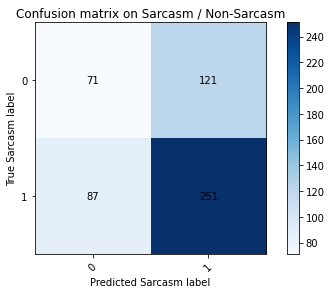

In [ ]:
# Plotting the confusion matrix
import numpy as np
from matplotlib import pyplot as plt
from past.builtins import xrange
def plot_confusion_matrix(cm, target_names, title='Confusion matrix on Sarcasm / Non-Sarcasm', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Sarcasm label')
    plt.xlabel('Predicted Sarcasm label')

cm = metrics.confusion_matrix(test.sarcasm_label_actual, test.sarcasm_label, labels=[0, 1])
plot_confusion_matrix(cm, [0,1])

Classification Report on Sarcasm / Non-Sarcasm
         
         Class       precision   recall  f1-score   support

           0         0.45        0.37      0.41       192
           1         0.67        0.74      0.71       338

    accuracy                               0.61       530
    macro avg        0.56        0.56      0.56       530
    weighted avg     0.59        0.61      0.60       530


# New Section